# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [11]:
student1 = "Marshall Cooper"
student2 = "Andrea Piccione"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [12]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam

### Plotting

In [13]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [14]:
from keras.datasets import mnist, fashion_mnist
...

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

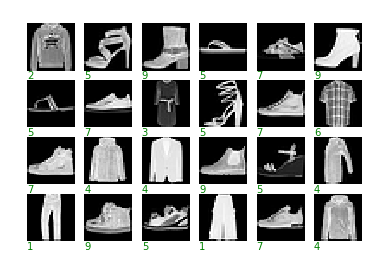

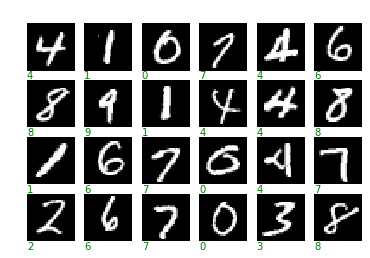

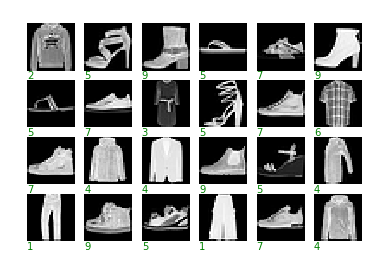

In [15]:
plot_some_samples(x_train, y_train)
plot_some_samples(x_fashion_train, y_fashion_train)

Answer to question 2:

The green number at the bottom left of each image is the number of the class that the image belongs to.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [16]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [17]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [18]:
## Set parameters to be used throughout
default_batch_size = 128
## Define model constructor to be used throughout
def construct_model(n=0, widths=(), activation='relu'):
    ''' Constructs and returns an unbuilt/uncompiled keras Sequential model with Dense layers meeting the given specifications.
    
    Parameters:
    n (int): Number of hidden layers, default 0
    widths (tuple): Number of neurons in each hidden layer, default empty
    activation (str): Activation function to be used by all hidden layers, default 'relu'
    
    Returns:
    keras.Sequential: Model meeting specified parameters
    
    '''
    assert len(widths)==n ## Must have a width specified for each hidden layer
    model = Sequential()
    first = True ## First layer only requires input shape
    ## Add each hidden layer
    for i in range(n):
        if first:
            model.add(Dense(widths[i], activation=activation, input_shape=x_train.shape[1:]))
            first = False
        else:
            model.add(Dense(widths[i], activation=activation))
    ## Add output layer as 10-unit softmax
    if first:
        model.add(Dense(10, activation='softmax', input_shape=x_train.shape[1:]))
    else:
        model.add(Dense(10, activation='softmax'))
    return model

In [10]:
## Build model, fit with early stopping on validation loss
mnist_0hl = construct_model()
mnist_0hl.compile(optimizer='sgd',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
## Fit model
mnist_0hl.fit(x_train, y_train, batch_size=default_batch_size, epochs=1000, validation_split=0.2, verbose=0, callbacks=[es])
## Plot learning curve
plot_history(mnist_0hl.history, "No Hidden Layer MNIST Learning Curve")

KeyboardInterrupt: 

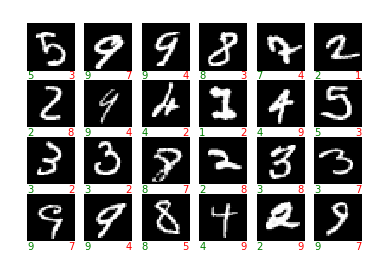

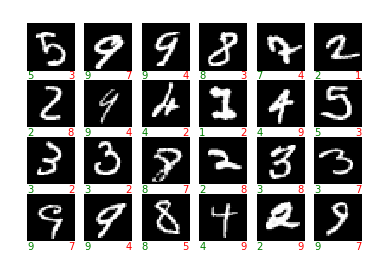

In [10]:
## Plot samples where model prediction failed
y_pred = keras.utils.to_categorical(mnist_0hl.predict_classes(x_test))
y_pred_classes = np.apply_along_axis(lambda x: np.min(np.nonzero(x)), 1, y_pred)
y_test_classes = np.apply_along_axis(lambda x: np.min(np.nonzero(x)), 1, y_test)
error_indices = np.nonzero(y_pred_classes!=y_test_classes)[0]
plot_some_samples(x_test, y=y_test, yhat=y_pred, select_from=error_indices)

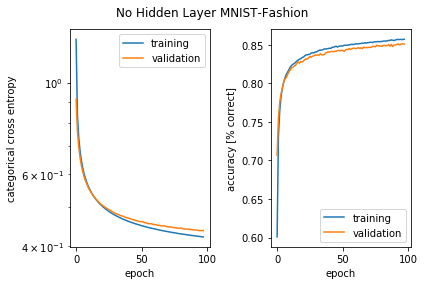

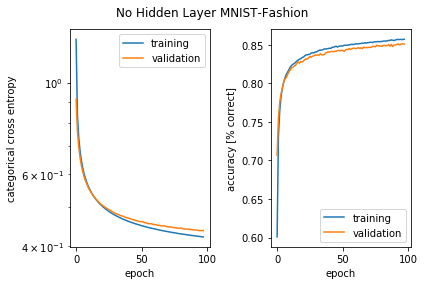

In [11]:
## Build model, fit with early stopping on validation loss
fmnist_0hl = construct_model()
fmnist_0hl.compile(optimizer='sgd',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
es = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
## Fit model
fmnist_0hl.fit(x_fashion_train, y_fashion_train, batch_size=default_batch_size, epochs=1000, validation_split=0.2, verbose=0, callbacks=[es])
## Plot learning curve
plot_history(fmnist_0hl.history, "No Hidden Layer MNIST-Fashion Learning Curve")

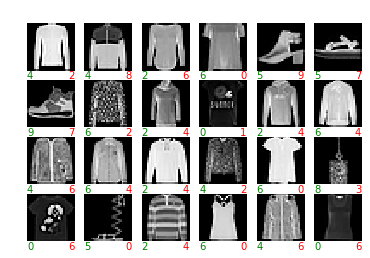

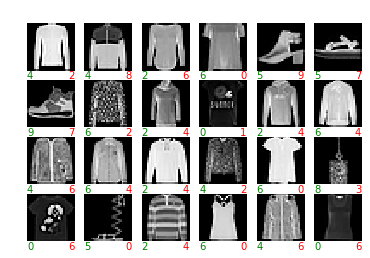

In [12]:
## Plot samples where model prediction failed
y_pred = keras.utils.to_categorical(fmnist_0hl.predict_classes(x_fashion_test))
y_pred_classes = np.apply_along_axis(lambda x: np.min(np.nonzero(x)), 1, y_pred)
y_test_classes = np.apply_along_axis(lambda x: np.min(np.nonzero(x)), 1, y_fashion_test)
error_indices = np.nonzero(y_pred_classes!=y_test_classes)[0]
plot_some_samples(x_fashion_test, y=y_fashion_test, yhat=y_pred, select_from=error_indices)

Answer to question 10:

The green labels denote the actual class the image belongs to, while the red labels denote the predicted class.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [13]:
model_1hl = construct_model(1, (128,))
model_1hl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [41]:
def test_learning_rates(rates, opt_name="SGD"):
    ''' Tests a single hidden layer model over 50 epochs with different learning rates on MNIST.
    Parameters:
    rates (list): List of learning rates to be tested
    opt_name (str): Name of the optimizer to use
    
    Returns:
    dictionary: Learning (rate -> history) pairs
    '''
    histories = dict()
    for rate in rates:
        model = construct_model(1, (128,))
        if opt_name=="Adam":
            opt = Adam(lr=rate)
        else:
            opt = SGD(lr=rate)
        model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        model.fit(x_train, y_train, batch_size=default_batch_size, epochs=50, validation_data = (x_test, y_test), verbose=0)
        histories[rate] = model.history
        acc = model.history.history['val_acc'][-1]
        acc = model.history.history['val_loss'][-1]
        print("{0} optimizer with {1} learning rate achieves {2} validation accuracy in 50 epochs.".
              format(opt_name,rate,acc))
    return histories

In [66]:
## Test spanning different orders of magnitude, with many samples in the [0.01, 0.1] range
learning_rates = [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, .5, 0.75, 1]
SGD_histories = test_learning_rates(learning_rates, "SGD") 
Adam_histories = test_learning_rates(learning_rates, "Adam") 

SGD optimizer with 0.001 learning rate achieves 0.9069 validation accuracy in 50 epochs.
SGD optimizer with 0.01 learning rate achieves 0.9565 validation accuracy in 50 epochs.
SGD optimizer with 0.025 learning rate achieves 0.9739 validation accuracy in 50 epochs.
SGD optimizer with 0.05 learning rate achieves 0.9767 validation accuracy in 50 epochs.
SGD optimizer with 0.075 learning rate achieves 0.9799 validation accuracy in 50 epochs.
SGD optimizer with 0.1 learning rate achieves 0.9807 validation accuracy in 50 epochs.
SGD optimizer with 0.25 learning rate achieves 0.9806 validation accuracy in 50 epochs.
SGD optimizer with 0.5 learning rate achieves 0.1912 validation accuracy in 50 epochs.
SGD optimizer with 0.75 learning rate achieves 0.9813 validation accuracy in 50 epochs.
SGD optimizer with 1 learning rate achieves 0.9791 validation accuracy in 50 epochs.
Adam optimizer with 0.001 learning rate achieves 0.9809 validation accuracy in 50 epochs.
Adam optimizer with 0.01 learnin

In [67]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

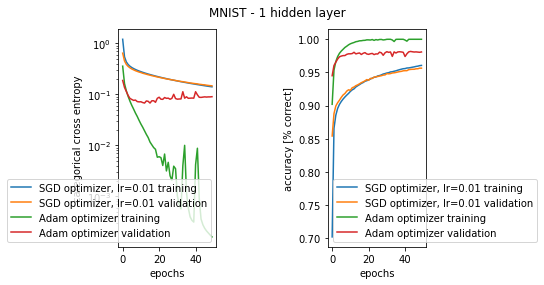

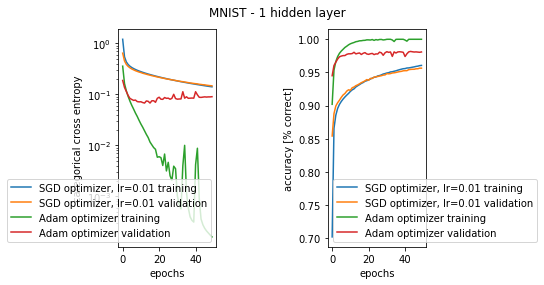

In [71]:
comparison_plot(SGD_histories[.01], Adam_histories[.001], "SGD optimizer, lr=0.01", "Adam optimizer", "MNIST - 1 hidden layer")

In [ ]:
## TODO Run Adam on FMNIST

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) When the learning rate is very large, SGD overshoots minima and either fluctuates around the minima (failing to find them precisely) or diverges completely.

B) When the learning rate is very small, SGD approaches minima very slowly and may be unable to do so in a limited number of epochs.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: This occurs near the 5th epoch.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: When overfitting, the training loss continues to decrease while the validation loss begins to increase after a certain epoch. When overfitting, the training and validation accuracies stop improving after a certain epoch, but do not necessarily decrease.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [83]:
def test_widths(widths, train, validation):
    ''' Tests a single hidden layer model over 10 epochs with numbers of neurons in the hidden layer
    Parameters:
    widths (list): List of widths to be tested
    train (tuple): training set as (x, y) tuple
    validation (tuple): validation set as (x, y) tuple
    
    Returns:
    dictionary: Learning (width -> history) pairs
    '''
    histories = dict()
    x, y = train
    for width in widths:
        model = construct_model(1, (width,))
        model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        model.fit(x, y, batch_size=default_batch_size, epochs=20, validation_data = validation, verbose=0)
        histories[width] = model.history
        acc = np.max(model.history.history['val_acc'])
        epoch = np.argmax(model.history.history['val_acc'])
        print("Single layer model with {0} hidden neurons achieves {1} validation accuracy at {2} epochs.".
              format(width,acc,epoch))
    return histories

# Helper function to plot validation loss and accuracy versus number of hidden layers
def plot_history_per_neurons(configurations, losses, accuracies, title):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('validation loss')
    ax1.set_yscale("linear")
    ax1.set_xlabel("number of neurons")
    ax2.set_ylabel('validation accuracy')
    ax2.set_xlabel("number of neurons")
    ax1.plot(configurations, losses)
    ax2.plot(configurations, accuracies)
    return fig

In [80]:
sizes = [10, 250, 500, 750, 1000]
mnist_width_histories = test_widths(sizes, (x_train, y_train), (x_test, y_test))

Single layer model with 10 hidden neurons achieves 0.9401 validation accuracy at 15 epochs.
Single layer model with 250 hidden neurons achieves 0.9817 validation accuracy at 16 epochs.
Single layer model with 500 hidden neurons achieves 0.9836 validation accuracy at 17 epochs.
Single layer model with 750 hidden neurons achieves 0.9824 validation accuracy at 13 epochs.
Single layer model with 1000 hidden neurons achieves 0.9827 validation accuracy at 6 epochs.


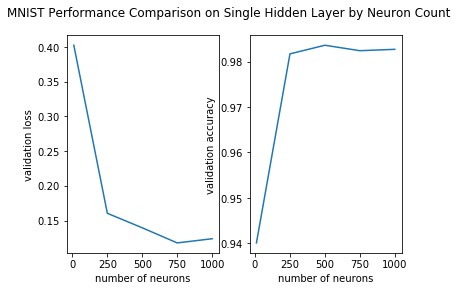

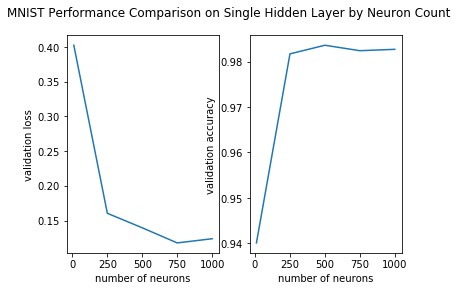

In [102]:
accs = list(map(lambda x: np.max(x.history['val_acc']),[mnist_width_histories[i] for i in sizes]))
losses = list(map(lambda x: np.max(x.history['val_loss']),[mnist_width_histories[i] for i in sizes]))
plot_history_per_neurons(sizes, losses, accs, "MNIST Performance Comparison on Single Hidden Layer by Neuron Count")

In [98]:
fmnist_width_histories = test_widths(sizes, (x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test))

Single layer model with 10 hidden neurons achieves 0.8556 validation accuracy at 15 epochs.
Single layer model with 250 hidden neurons achieves 0.8927 validation accuracy at 16 epochs.
Single layer model with 500 hidden neurons achieves 0.8943 validation accuracy at 17 epochs.
Single layer model with 750 hidden neurons achieves 0.8984 validation accuracy at 19 epochs.
Single layer model with 1000 hidden neurons achieves 0.8943 validation accuracy at 16 epochs.


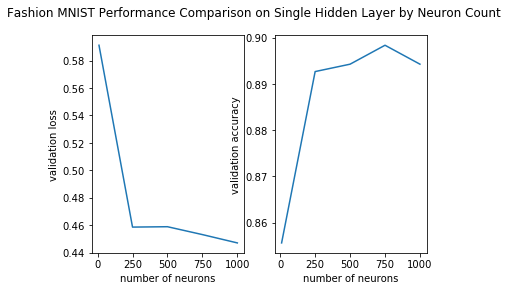

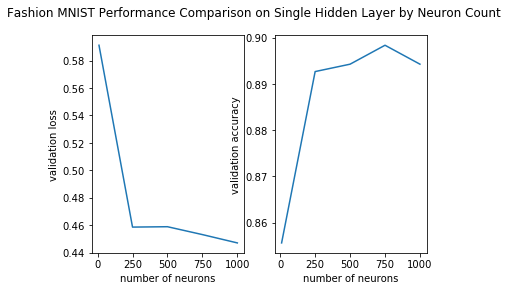

In [103]:
accs = list(map(lambda x: np.max(x.history['val_acc']),[fmnist_width_histories[i] for i in sizes]))
losses = list(map(lambda x: np.max(x.history['val_loss']),[fmnist_width_histories[i] for i in sizes]))
plot_history_per_neurons(sizes, losses, accs, "Fashion MNIST Performance Comparison on Single Hidden Layer by Neuron Count")

Answer to question 2:

This appears to be in accordance with the general approximation theorem. When the count of hidden neurons exceeds the dimensionality of the input (as in the 750 and 1000 neuron test cases), it becomes expressive enough to 'memorize' the test data, and begins to overfit and perform worse on the validation set.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [34]:
## We add extra layers to our best model from above (750-unit single layer)
def construct_multilayers(n, title, train, validation, norm = False, dropout = 0, weight_reg = None, bias_reg = None):
    ''' Constructs a 750-unit single layer Dense model and adds additional layers meeting given parameters.
    Parameters:
    n(list): Number of extra  hidden layers
    title(str): Name of model
    train (tuple): training set as (x, y) tuple
    validation (tuple): validation set as (x, y) tuple
    norm(boolean): Whether or not batch normalization is used between hidden layer, default False
    dropout(double): Amount of dropout used between
    weight_reg(str): Name of regularizer for weights, default None
    bias_reg(str): Name of regularizer for biases, default None
    
    Returns:
    keras.Sequential: Model meeting specified parameters
    '''
    x, y = train
    model = Sequential(name=title)
    first = True
    for i in range(n+1):
        ## Add a dense layer; use_bias is False if we are using batch normalization
        if first:
            model.add(Dense(750, activation='relu', kernel_regularizer=weight_reg, bias_regularizer=bias_reg, 
                            use_bias=norm!=0, input_shape=x_train.shape[1:]))
            first = False
        else:
            model.add(Dense(50, activation='relu', kernel_regularizer=weight_reg, bias_regularizer=bias_reg, 
                            use_bias=norm!=0))
        ## If using dropout, add it with the specified rate
        if dropout:
            model.add(Dropout(dropout))
        ## If using batch normalization   
        if norm:
            model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax')) ## Add output layer
    return model

In [35]:
## Construct simple variations
l1 = keras.regularizers.l1
l2 = keras.regularizers.l2
naive = construct_multilayers(2, "Naive", (x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test))
batch_norm = construct_multilayers(2, "Batch Normalized", (x_fashion_train, y_fashion_train), 
                                   (x_fashion_test, y_fashion_test), norm=True)
dropout_10 = construct_multilayers(2, "Dropout 10", (x_fashion_train, y_fashion_train), 
                                   (x_fashion_test, y_fashion_test), dropout=0.1)
dropout_25 = construct_multilayers(2, "Dropout 25", (x_fashion_train, y_fashion_train), 
                                   (x_fashion_test, y_fashion_test), dropout=0.25)
dropout_50 = construct_multilayers(2, "Dropout 50", 
                                   (x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test), dropout=0.5)
l1_bias = construct_multilayers(2, "L1 on Biases", (x_fashion_train, y_fashion_train), 
                                (x_fashion_test, y_fashion_test), bias_reg=l1)
l1_kernel = construct_multilayers(2, "L1 on Weights", (x_fashion_train, y_fashion_train), 
                                  (x_fashion_test, y_fashion_test), weight_reg=l1)
l1_both = construct_multilayers(2, "L1 on Both", (x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test),
                                weight_reg=l1, bias_reg=l1)
l2_bias = construct_multilayers(2, "L2 on Biases", (x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test),
                                bias_reg=l2)
l2_kernel = construct_multilayers(2, "L2 on Weights", (x_fashion_train, y_fashion_train), 
                                  (x_fashion_test, y_fashion_test), weight_reg=l2)
l2_both = construct_multilayers(2, "L2 on Both", (x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test),
                                weight_reg=l2, bias_reg=l2)

simple_models = [naive, batch_norm, dropout_10, dropout_25, dropout_50, l1_bias, 
                 l1_kernel, l1_both, l2_bias, l2_kernel, l2_both]

In [36]:
## Evaluate all models
for model in simple_models:
    print("Testing {0}:".format(model.name))
    model.compile(optimizer="Adam",
      loss='categorical_crossentropy',
      metrics=['accuracy'])
    model.fit(x_fashion_train, y_fashion_train, batch_size=default_batch_size, epochs=100, 
              validation_data = (x_fashion_test, y_fashion_test), verbose=0)
    best = np.argmin(model.history.history['val_loss'])
    loss = model.history.history['val_loss'][best]
    acc = model.history.history['val_acc'][best]
    print("\tAchieved {0} validation loss and {1} validation accuracy at epoch {2}. (best loss)".format(loss,acc,best))
    best = np.argmax(model.history.history['val_acc'])
    loss = model.history.history['val_loss'][best]
    acc = model.history.history['val_acc'][best]
    print("\tAchieved {0} validation loss and {1} validation accuracy at epoch {2}. (best accuracy)".format(loss,acc,best))
    

Testing Naive:
	Achieved 0.32749026284217836 validation loss and 0.8862 validation accuracy at epoch 8. (best loss)
	Achieved 0.6066443263274618 validation loss and 0.9002 validation accuracy at epoch 79. (best accuracy)
Testing Batch Normalized:
	Achieved 0.344321214389801 validation loss and 0.8809 validation accuracy at epoch 12. (best loss)
	Achieved 0.57543315076828 validation loss and 0.8873 validation accuracy at epoch 85. (best accuracy)
Testing Dropout 10:
	Achieved 0.3140040066242218 validation loss and 0.8896 validation accuracy at epoch 16. (best loss)
	Achieved 0.406494460952282 validation loss and 0.9038 validation accuracy at epoch 63. (best accuracy)
Testing Dropout 25:
	Achieved 0.3147480418205261 validation loss and 0.8936 validation accuracy at epoch 27. (best loss)
	Achieved 0.3972216377258301 validation loss and 0.9017 validation accuracy at epoch 98. (best accuracy)
Testing Dropout 50:
	Achieved 0.34243207125663755 validation loss and 0.8854 validation accuracy at

In [21]:
## Construct complex variations (combinations of technqiues)
## To keep the search space reasonable, we only investigate combinations with dropout=10
l2_dropout = construct_multilayers(2, "Dropout 10; l2", (x_fashion_train, y_fashion_train), 
                                   (x_fashion_test, y_fashion_test), dropout=0.1, weight_reg='l2')
l2_batch_norm = construct_multilayers(2, "l2; batch normalized", (x_fashion_train, y_fashion_train), 
                                   (x_fashion_test, y_fashion_test), norm=True, weight_reg='l2')
l2_dropout_batch_norm = construct_multilayers(2, "Dropout 10; l2; batch normalized", 
                                              (x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test), 
                                              dropout=0.1, norm=True, weight_reg='l2')

complex_models = [l2_dropout, l2_batch_norm, l2_dropout_batch_norm]

In [22]:
## Evaluate all models
for model in complex_models:
    print("Testing {0}:".format(model.name))
    model.compile(optimizer="Adam",
      loss='categorical_crossentropy',
      metrics=['accuracy'])
    model.fit(x_fashion_train, y_fashion_train, batch_size=default_batch_size, epochs=100, 
              validation_data = (x_fashion_test, y_fashion_test), verbose=0)
    best = np.argmin(model.history.history['val_loss'])
    loss = model.history.history['val_loss'][best]
    acc = model.history.history['val_acc'][best]
    print("\tAchieved {0} validation loss and {1} validation accuracy at epoch {2}. (best loss)".format(loss,acc,best))
    best = np.argmax(model.history.history['val_acc'])
    loss = model.history.history['val_loss'][best]
    acc = model.history.history['val_acc'][best]
    print("\tAchieved {0} validation loss and {1} validation accuracy at epoch {2}. (best accuracy)".format(loss,acc,best))

Testing Dropout 10; l2:
	Achieved 0.5631215826034546 validation loss and 0.8522 validation accuracy at epoch 94. (best loss)
	Achieved 0.578432068824768 validation loss and 0.8528 validation accuracy at epoch 64. (best accuracy)
Testing l2; batch normalized:
	Achieved 0.4469008964061737 validation loss and 0.8603 validation accuracy at epoch 85. (best loss)
	Achieved 0.4767956081867218 validation loss and 0.8626 validation accuracy at epoch 14. (best accuracy)
Testing Dropout 10; l2; batch normalized:
	Achieved 0.5038084309577942 validation loss and 0.8442 validation accuracy at epoch 80. (best loss)
	Achieved 0.5045358013629914 validation loss and 0.8478 validation accuracy at epoch 81. (best accuracy)


Answer to question 2 (comments):

In this ex

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [22]:
from keras.layers import Reshape

In [ ]:
# Model from mnist_cnn on keras examples folder

model_mnist_cnn = Sequential()
model_mnist_cnn.add(Reshape((28, 28, 1), input_shape=(x_train.shape[1],)))
model_mnist_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_mnist_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_mnist_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_mnist_cnn.add(Dropout(0.25))
model_mnist_cnn.add(Flatten())
model_mnist_cnn.add(Dense(128, activation='relu'))
model_mnist_cnn.add(Dropout(0.5))
model_mnist_cnn.add(Dense(y_train.shape[1], activation='softmax'))

model_mnist_cnn.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=['accuracy'])

history_mnist_cnn = model_mnist_cnn.fit(x_train, y_train, batch_size=128, epochs=10, verbose=0, validation_data=(x_test, y_test))
plot_history(history_mnist_cnn, title = "MNIST CNN")
score = model_mnist_cnn.evaluate(x_test, y_test)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

In [ ]:
# Deeper structure with an additional CONV2D - CONV2D - MAXPOOL - DROPOUT

model_mnist_cnn_adv = Sequential()
model_mnist_cnn_adv.add(Reshape((28, 28, 1), input_shape=(x_train.shape[1],)))
model_mnist_cnn_adv.add(Conv2D(32, (3,3), activation ='relu'))
model_mnist_cnn_adv.add(Conv2D(64, (3,3), activation ='relu'))
model_mnist_cnn_adv.add(MaxPooling2D(pool_size=(2,2)))
model_mnist_cnn_adv.add(Dropout(0.25))
model_mnist_cnn_adv.add(Conv2D(32, (3,3), activation ='relu'))
model_mnist_cnn_adv.add(Conv2D(64, (3,3), activation ='relu'))
model_mnist_cnn_adv.add(MaxPooling2D(pool_size=(2,2)))
model_mnist_cnn_adv.add(Dropout(0.25))
model_mnist_cnn_adv.add(Flatten())
model_mnist_cnn_adv.add(Dense(128, activation = "relu"))
model_mnist_cnn_adv.add(Dropout(0.5))
model_mnist_cnn_adv.add(Dense(y_train.shape[1], activation = "softmax"))

# optimizer
model_mnist_cnn_adv.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=['accuracy'])

history_mnist_cnn_adv = model_mnist_cnn_adv.fit(x_train, y_train, batch_size=128, epochs=10, verbose=0, validation_data=(x_test, y_test))
plot_history(history_mnist_cnn_adv, title = "MNIST CNN ADV adadelta")
score = model_mnist_cnn_adv.evaluate(x_test, y_test)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

In [ ]:
# Inspiration from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
# Same as before but with different optimizer and parameters

model_mnist_cnn_adv = Sequential()
model_mnist_cnn_adv.add(Reshape((28, 28, 1), input_shape=(x_train.shape[1],)))
model_mnist_cnn_adv.add(Conv2D(32, (3,3), activation ='relu'))
model_mnist_cnn_adv.add(Conv2D(64, (3,3), activation ='relu'))
model_mnist_cnn_adv.add(MaxPooling2D(pool_size=(2,2)))
model_mnist_cnn_adv.add(Dropout(0.25))
model_mnist_cnn_adv.add(Conv2D(32, (3,3), activation ='relu'))
model_mnist_cnn_adv.add(Conv2D(64, (3,3), activation ='relu'))
model_mnist_cnn_adv.add(MaxPooling2D(pool_size=(2,2)))
model_mnist_cnn_adv.add(Dropout(0.25))
model_mnist_cnn_adv.add(Flatten())
model_mnist_cnn_adv.add(Dense(128, activation = "relu"))
model_mnist_cnn_adv.add(Dropout(0.5))
model_mnist_cnn_adv.add(Dense(y_train.shape[1], activation = "softmax"))

# optimizer
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_mnist_cnn_adv.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

history_mnist_cnn_adv = model_mnist_cnn_adv.fit(x_train, y_train, batch_size=128, epochs=10, verbose=0, validation_data=(x_test, y_test))
plot_history(history_mnist_cnn_adv, title = "MNIST CNN ADV RMSprop")
score = model_mnist_cnn_adv.evaluate(x_test, y_test)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

In [ ]:
# Deeper structure, inspiration from https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457

model_mnist_cnn_deep = Sequential()
model_mnist_cnn_deep.add(Reshape((28, 28, 1), input_shape=(x_train.shape[1],)))
model_mnist_cnn_deep.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model_mnist_cnn_deep.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model_mnist_cnn_deep.add(MaxPool2D((2, 2)))
model_mnist_cnn_deep.add(Dropout(0.2))
model_mnist_cnn_deep.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_mnist_cnn_deep.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_mnist_cnn_deep.add(MaxPool2D(pool_size=(2, 2)))
model_mnist_cnn_deep.add(Dropout(0.25))
model_mnist_cnn_deep.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_mnist_cnn_deep.add(Dropout(0.25))
model_mnist_cnn_deep.add(Flatten())
model_mnist_cnn_deep.add(Dense(128, activation='relu'))
model_mnist_cnn_deep.add(BatchNormalization())
model_mnist_cnn_deep.add(Dropout(0.25))
model_mnist_cnn_deep.add(Dense(y_train.shape[1], activation = "softmax"))

model_mnist_cnn_deep.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

history_mnist_cnn_deep = model_mnist_cnn_deep.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))
plot_history(history_mnist_cnn_deep, title = "MNIST CNN DEEP")
score = model_mnist_cnn_deep.evaluate(x_test, y_test)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

#### Fashion-MNIST

In [23]:
# Model from mnist_cnn on keras examples folder

model_fashion_cnn = Sequential()
model_fashion_cnn.add(Reshape((28, 28, 1), input_shape=(x_train.shape[1],)))
model_fashion_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_fashion_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_fashion_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_fashion_cnn.add(Dropout(0.25))
model_fashion_cnn.add(Flatten())
model_fashion_cnn.add(Dense(128, activation='relu'))
model_fashion_cnn.add(Dropout(0.5))
model_fashion_cnn.add(Dense(y_train.shape[1], activation='softmax'))

model_fashion_cnn.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=['accuracy'])

history_fashion_cnn = model_fashion_cnn.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=10, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
plot_history(history_fashion_cnn, title = "MNIST CNN")
score = model_fashion_cnn.evaluate(x_fashion_test, y_fashion_test)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

NameError: name 'Reshape' is not defined

In [ ]:
# Simple cnn model, https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a

model_fashion_cnn = Sequential()
model_fashion_cnn.add(Reshape((28, 28, 1), input_shape=(x_fashion_train.shape[1],)))
model_fashion_cnn.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')) 
model_fashion_cnn.add(MaxPooling2D(pool_size=2))
model_fashion_cnn.add(Dropout(0.3))
model_fashion_cnn.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model_fashion_cnn.add(MaxPooling2D(pool_size=2))
model_fashion_cnn.add(Dropout(0.3))
model_fashion_cnn.add(Flatten())
model_fashion_cnn.add(Dense(256, activation='relu'))
model_fashion_cnn.add(Dropout(0.5))
model_fashion_cnn.add(Dense(y_fashion_train.shape[1], activation='softmax'))

model_fashion_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_fashion_cnn = model_fashion_cnn.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=10, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
plot_history(history_fashion_cnn, title = "FASHION CNN")
score = model_fashion_cnn.evaluate(x_fashion_test, y_fashion_test)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

In [ ]:
# Another simple model https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist

model_fashion_cnn = Sequential()
model_fashion_cnn.add(Reshape((28, 28, 1), input_shape=(x_fashion_train.shape[1],)))
model_fashion_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
model_fashion_cnn.add(MaxPooling2D((2, 2)))
model_fashion_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_fashion_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_fashion_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_fashion_cnn.add(Flatten())
model_fashion_cnn.add(Dense(128, activation='relu'))
model_fashion_cnn.add(Dense(y_fashion_train.shape[1], activation='softmax'))

model_fashion_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

history_fashion_cnn = model_fashion_cnn.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=10, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
plot_history(history_fashion_cnn, title = "FASHION CNN")
score = model_fashion_cnn.evaluate(x_fashion_test, y_fashion_test)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [ ]:
from keras.layers import BatchNormalization

In [ ]:
# Deeper structure with an additional CONV2D - CONV2D - MAXPOOL - DROPOUT and relu

model_mnist_cnn_sigm = Sequential()
model_mnist_cnn_sigm.add(Reshape((28, 28, 1), input_shape=(x_train.shape[1],)))
model_mnist_cnn_sigm.add(BatchNormalization())
model_mnist_cnn_sigm.add(Conv2D(32, (3,3), activation ='sigmoid'))
model_mnist_cnn_sigm.add(Conv2D(64, (3,3), activation ='sigmoid'))
model_mnist_cnn_sigm.add(MaxPooling2D(pool_size=(2,2)))
model_mnist_cnn_sigm.add(Dropout(0.25))
model_mnist_cnn_sigm.add(Conv2D(32, (3,3), activation ='sigmoid'))
model_mnist_cnn_sigm.add(Conv2D(64, (3,3), activation ='sigmoid'))
model_mnist_cnn_sigm.add(MaxPooling2D(pool_size=(2,2)))
model_mnist_cnn_sigm.add(Dropout(0.25))
model_mnist_cnn_sigm.add(Flatten())
model_mnist_cnn_sigm.add(Dense(128, activation = "sigmoid"))
model_mnist_cnn_sigm.add(Dropout(0.5))
model_mnist_cnn_sigm.add(Dense(y_train.shape[1], activation = "softmax"))

# optimizer
model_mnist_cnn_sigm.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=['accuracy'])

history_mnist_cnn_sigm = model_mnist_cnn_sigm.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))
plot_history(history_mnist_cnn_sigm, title = "MNIST CNNv2 adadelta - sigmoid")
score = model_mnist_cnn_sigm.evaluate(x_test, y_test)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Answer to question 1:

Answer to question 2: